In [2]:
from utils import *
from fluxtower_parse import *
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows

In [3]:
# Get Metek data

# If metek files don't already exsist, extract using the below:

# To update raw data files: 
# rsync -azvp fluxtower@192.168.1.211:/home/data/fluxtower_data_transfer/ /Users/heather/ICECAPS-ACE/Data/.

# To extract metek files:
#dname = 'metek'
#dloc = '/Users/heather/ICECAPS-ACE/Data/'
#extract_out = '/Users/heather/ICECAPS-ACE/temp_data/'
#extract_tar(dloc,extract_out,dname)

# If extracted files already exist, just give the d loction:
dpath = '/Users/heather/ICECAPS-ACE/temp_data/home/data/'
log_metek = '/Users/heather/ICECAPS-ACE/log_metek.txt'

# Start and stop date:
start = dt.datetime(2019,6,1,16,0)
stop = dt.datetime(2019,6,1,16,15)

# Parse data into dataframe using the following function from fluxtower parse:
m1,m2 = extract_metek_data(start,stop,dpath,log_metek)

In [4]:
# Get Licor data
# If licor files don't already exsist, extract using the below:
# To update raw data files: 
# rsync -azvp fluxtower@192.168.1.211:/home/data/fluxtower_data_transfer/ /Users/heather/ICECAPS-ACE/Data/.

# To extract licor files:
#dname = 'licor'
#dloc = '/Users/heather/ICECAPS-ACE/Data/FLUX_compressed/'
#extract_out = '/Users/heather/ICECAPS-ACE/temp_data/'
#extract_tar(dloc,extract_out,dname)

# If extracted files already exist, just give the d loction:
dpath = '/Users/heather/ICECAPS-ACE/temp_data/home/data/'
log_licor = '/Users/heather/ICECAPS-ACE/log_licor.txt'

licor = extract_licor_data(start,stop,dpath,log_licor)

Skipping line 35: expected 10 fields, saw 18



In [5]:
# Clean Metek data
# Based on clean_metek.m by IAM, 25/7/2014
# metek = clean_metek(metek)
# INPUT
#  metek  - data strucure
# OUTPUT
#  metek  - data structure
# wind compents and sonic temperature are cleaned up:
# - the time series are filtered for outliers, these are replaced with  
#   median filtered values
# - missing values from error messages (NaNs) are then interpolated over? - not done yet

# Change units from cm/s to m/s, (* 0.01)
m1['x']=m1['x']*0.01
m1['y']=m1['y']*0.01
m1['z']=m1['z']*0.01

m2['x']=m2['x']*0.01
m2['y']=m2['y']*0.01
m2['z']=m2['z']*0.01

# filter for clear outliers - replace with median filtered values
#set limit at 3*standard deviation of vertical wind component

jj = ~np.isnan(m1.z) # Not nan indices
m1_sd = np.std(m1.z[jj]) # standard deviation of vertical wind component. 

jj = ~np.isnan(m2.z) # Not nan indices
m2_sd = np.std(m2.z[jj]) # standard deviation of vertical wind component. 

# replace outliers with median filter
def replace_outliers(var,sd):
    var=var.astype(float)
    jj = ~np.isnan(var) # Ignore nans
    temp = var[jj]
    mf = medfilt(temp,11)             # Get median filter
    ii = np.abs(temp - mf) > 3*sd     # Get outliers, where greated than 3 Sd's from median
    temp[ii] = mf[ii]                 # Replace these outliers with the median
    var_clean = var
    var_clean[jj] = temp      # Put back into orginal array/
    
    return var_clean

m1['x_clean']=replace_outliers(m1['x'],m1_sd)
m1['y_clean']=replace_outliers(m1['y'],m1_sd)
m1['z_clean']=replace_outliers(m1['z'],m1_sd)
m1['T_clean']=replace_outliers(m1['T'],m1_sd)

m2['x_clean']=replace_outliers(m2['x'],m2_sd)
m2['y_clean']=replace_outliers(m2['y'],m2_sd)
m2['z_clean']=replace_outliers(m2['z'],m2_sd)
m2['T_clean']=replace_outliers(m2['T'],m2_sd)

# patch up missing data from records with error messages by interpolation
# metek output should be 10Hz
# 10Hz = 0.1s = 100 ms
m1 = m1.resample('100L').mean().interpolate()
m2 = m2.resample('100L').mean().interpolate()

In [6]:
# Do cross wind temperature correction
# Adapted from Ts_sidewind_correction.m by IMB July 2007
#     Correct contamination of sonic temperature measurement for lengthening of
#     sonic path by sidewind. 
#
#function T = Ts_sidewind_correction(Ts,u,v,w,model);
# INPUTS
#  Ts    : sonic temperature (K)
#  u,v,w : wind components in sonic measurement frame (before any rotations,
#          motion correction, etc) (m/s)

# OUTPUT
#  T     : corrected temperature (K)
#
#     Correction follows van Dijk et al. 2004: The
#     principles of surface flux physics: theory, practice and description of
#     the ECPACK library (www.met.wau.nl/projects/jep). See also: Liu et al.
#     2001: BLM, 100, 459-468, and Schotanus et al. 1983: BLM, 26, 81-93.

def Ts_sidewind_correction(Ts,u,v,w):
    vn2 = (3/4)*(u**2 + v**2) + 0.5*w**2
    T = Ts + vn2/403
    return T

m1['T_corrected'] = Ts_sidewind_correction(m1['T_clean'].astype(float),m1['x'].astype(float),m1['y'].astype(float),m1['z'].astype(float))
m2['T_corrected'] = Ts_sidewind_correction(m2['T_clean'].astype(float),m2['x'].astype(float),m2['y'].astype(float),m2['z'].astype(float))

# Convert T corrected to kelvin
m1['T_corrected']= m1['T_corrected']+ 273.15
m2['T_corrected']= m2['T_corrected']+ 273.15

In [7]:
# Correct tilt and align with horizontal streamlinge over a single run (~20mins)
# Adapted from rotate_to_run.m by IMB July 2006
#% references:
#%  Wilczak et al. 2001: sonic anemometer tilt corrections. BLM, 99, 127-150
#%  (but beware typos in equations)
#%  Kaimal & Finnigan, 1994: Atmospheric Boundary Layer Flows: Their
#%  Structure and Measurement. Oxford University Press
#%  van Dijk et al. 2004: The principles of surface flux physics: theory,
#%  practice and description of the ECPACK library
#%  www.met.wau.nl/projects/jep

def rotate_to_run(um,vm,wm):
    #% First rotate to align x-axis with mean wind direction in sonic's
    #% reference frame
    
    theta=np.arctan2(np.mean(vm),np.mean(um))
    u1 = um*np.cos(theta) + vm*np.sin(theta)
    v1 = -um*np.sin(theta) + vm*np.cos(theta)
    w1 = wm

    #% Next rotate u and w so that x-axis lies along mean streamline and 
    #% mean(w) is zero

    phi = np.arctan2(np.mean(w1),np.mean(u1))
    u2 = u1*np.cos(phi) + w1*np.sin(phi)
    v2 = v1
    w2=  -u1*np.sin(phi) + w1*np.cos(phi)

    # Theta is angle of rotation um-to-vm (anticlockwise or righthanded)
    # to aign u with mean wind (degrees)
    theta = theta*180/np.pi

    # phi is tilt angle (+ve tilts x-axis upwards) to align x-axis with
    # mean streamline and force <w>=0
    phi = phi*180/np.pi

    # Output wind components in streamline oriented reference frame, theta and phi

    return u2,v2,w2,theta,phi

um = m1.x_clean # measured wind components in sonic reference frame in cm/s
vm = m1.y_clean
wm = m1.z_clean

m1['u'],m1['v'],m1['w'],theta,phi = rotate_to_run(m1.x_clean,m1.y_clean,m1.z_clean)
m2['u'],m2['v'],m2['w'],theta,phi = rotate_to_run(m2.x_clean,m2.y_clean,m2.z_clean)



In [ ]:
# Use snow depth sensor to do absolute height correction

In [ ]:
# Calculate bulk richardson number
#Ri = richardson number
#Rig = gradient richardson number: 
#       provides a measure of the balance between shear and bouyant forces 
#       and the resultant turbulent state of the atmosphere, based on mean 
#       wind and thermodynamic profiles. Negative Rig is an indication of 
#       buoyancy-generated turbulence, positive values are associated with 
#       stably stratified turbulence.
# For simplicity, generally refer to Rig>1 as nonturbulent. 

# Rig = g/thetaV * (dthetaV/dz) / ((du**2/dz + dv**2/dz))
# thetaV = virtual potential temperature

# Approximate thetav with theta (potential temperature) for now. 
Rd = 287.0 # J/K/kg - gas constant of 1kg of dry air
P0 = 100000.0 # Standard reference pressure, Pa

# theta = T(P0/P)**(Rd/cp)




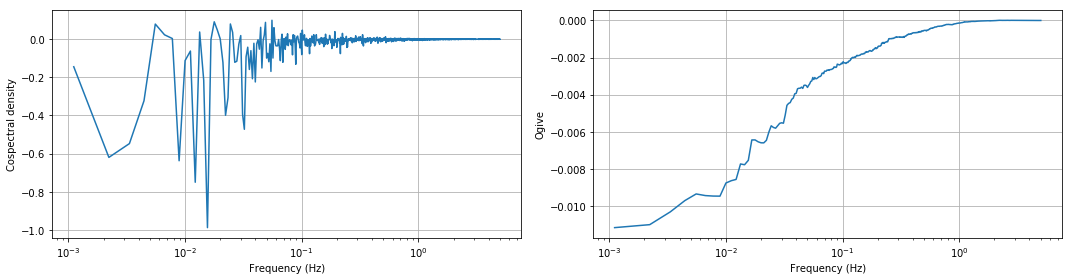

In [15]:
# Calculate cospectral density and ogive function. 

# Choose your two variables. 
x = m1['w']
y = m1['u']

sf = 10.0 # Sampling frequency
m = len(x)  ## Number of points used in fourier transfer, can be length of time series or less.
            #This should be chosen to give the averaging time you want. So if you
            #have 1-hour files of 10Hz data and want 20-minute averages, then
            #m = 10*20*60 = 12000
            #In practice you'd probably just take a (nominal) 12000 point subset of
            #the data and give that to the function, with m = length(data)

df = sf/m   # Delta frequency

f = np.arange(df,sf/2+df,df) # Frequency series
            
# Make sure m is even
m=np.fix(m/2)*2;

# Calculated using mathematical methods, fast fourier transform
# FFT gives the amplitudes of variation for different frequencies

# Calculate the FFT for x and for y. (normalised by the length of the time series)

xw=detrend(x)
yw=detrend(y)
Rxx = np.fft.fft(xw)/m
Ryy = np.fft.fft(yw)/m

#The cospectrum is:
Sxy = Rxx*np.conj(Ryy)

#The fourier spectra are complex and symmetrical about a frequency of 0
#(ie they have fourier components for both +ve and -ve frequency) -
#negative frequencies don't make sense in the real world, so we 'fold'
#the spectra about 0 and store as Gxy etc

Gxy = 2 * Sxy[1:int(m)/2]
Gxy =np.append(Gxy, Sxy[int(m)/2+1])

# Co-spectra: how much different sized eddies contribute to the covariance of two variables - the product of the fft of two variables. 
#Gxx, Gyy are the power spectra of x, y, Gxy is the cospectrum of x and
#y. The (co)spectral densities are simply these divided by the frequency
#interval to give power per unit frequency. The integral of this is the
#variance (or covariance) of the time series.

Csdxy = Gxy / df

# Ogive = cumulative co-spectrum. Use to find the point after which there is no flux contribution. Averaging peroiod should be longer
# than this so large eddies aren't lost, but otherwise as short as possible so that large scale changes (atmospheric) aren't included. 
n = len(Csdxy)
ogive = np.zeros(n)
ogive[0]=(Csdxy*df)[0]
for i in range(1,n):
    k=n-1-i
    ogive[k]=ogive[k+1]+(Csdxy*df)[k]

# Plot co spectral density and ogive function.

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.grid(True)
ax1.semilogx(f,Csdxy,label='cospectra')
ax1.set_ylabel('Cospectral density')
ax1.set_xlabel('Frequency (Hz)')
#ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(True)
ax2.semilogx(f,ogive,label='ogive function')
ax2.set_ylabel('Ogive')
ax2.set_xlabel('Frequency (Hz)')
#ax2.legend()

#ax.set_xlim(d1,d2)
fig.tight_layout()



In [8]:
# Function to calculate instantaneous flux 
def eddyflux(x,y):
    # x is time series of vertical velocity
    # y is parameter of interest.
    x = detrend(x)
    y = detrend(y)
    flux = np.mean(x*y) # Instantaneous flux
    std = np.std(x*y) # Standard deviation of instantaneous flux
    return flux,std

In [9]:
# Calculate sensible heat flux. 

# The EC method (e.g., Oke, 1987) calculates the covariance
# between the anomalies in the vertical wind (w') and temperature (T')
# to determine the turbulent sensible heat flux according to the following equation:
# SH = rho * cp * mean(w'*T')
# rho = density of air       
# cp = heat capacity of air

# To calculate mean(w'*T'), use ians eddyflux.m script
# Timeseries are first linearly detrended, then the mean covariance = flux is
# found 

# It represents the loss of energy by the
# surface by heat transfer to the atmosphere. It is positive when directed
# away from the surface into the atmosphere.

flux,std = eddyflux(m1['w'],m1['T_corrected']) # Flux units = Km/s

# For air denisty and heat capacity, for now lets use a constant assuming dry air and temps of -15C, pressure of 673mb.
# The licor measures air pressure, can probably make a better estimate using licor data (rho_dry = P/RT)
# Can probably also use temperature and humidty values to make a better estimate of heat capacity
rho = 0.8136 # kg/m3
cp = 1003    # j/kg*K

SHF = rho * cp * flux # W/m2


In [10]:
# Extract H2O mixing ratio from LiCOR. 
# H2OD: H2O density (mmol m-3)

Ma = 28.96    # Molar mass of dry air (g/mol)
Mh = 18.01528 # Molar mass of H2O (g/mol)
R = 8.314     # J/K/mol #universal gas constant

T = licor['T']+273.15      # K
P = licor['P']*1000        # Pa
Nconc_h2o = licor['H2OD']/1000 # mol/m3

mass_conc_air = (Ma*P)/(R*T) / 1000       # kg air/ m3
mass_conc_h2o = (Mh * Nconc_h2o) / 1000   # kg water / m3

q = mass_conc_h2o / mass_conc_air         # Mass mixing ratio

# Average q onto the same time series as w.
q = q.resample('100L').mean().interpolate()

# Calculate latent heat flux.
#It represents a loss of energy from the
#surface due to evaporation. 
# LH = L * rho * mean(w'*q')
# q = H2O mixing ratio
# L = latent heat of vaporisation of water = 2264705 j/kg

L = 2264705.0 # j/kg

flux,std = eddyflux(m1['w'],q)

LH = L * rho * flux